### Setup

In [0]:
# connect to google drive
import os
import numpy as np

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
# change root directory such that models are saved in google drive during training
root_dir = "/content/gdrive/My Drive/Taiger/Q4"
os.chdir(root_dir)
# print the contents
!ls

models	Q4.ipynb  xtest_obfuscated.txt	xtrain_obfuscated.txt  ytrain.txt


### Imports

In [0]:
# export
# basic packages
import time
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

# Keras preprocessing
from keras.preprocessing import text, sequence

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Fastai
from fastai.train import Learner
from fastai.train import DataBunch
from fastai.callbacks import *

# sklearn
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
# export
## Set seed for reproducing experiment results

def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed = 9461
seed_everything(seed)

### Load data and EDA

In [0]:
# export

def read_corpus(file_path):
    """ 
    read examples form the given dataset
    """
    data = []
    for line in open(file_path):
        chars = [char for char in line.strip()]
        #  Append <s> and </s> to the  sentence

        sent = ['<s>'] + chars + ['</s>']
        data.append(sent)

    return data

In [0]:
# export

# load data
X_train_path = 'xtrain_obfuscated.txt'
y_train_path = 'ytrain.txt'
X_test_path = 'xtest_obfuscated.txt'

X = read_corpus(X_train_path)
y = np.loadtxt(y_train_path)
X_test = read_corpus(X_test_path)

In [0]:
# Check maximum length of the strings

train_sent_len = [len(x) for x in X] 
test_sent_len = [len(x) for x in X_test] 

##
print('Max chars in train: {}'.format(max(train_sent_len)))
print('Min chars in train: {}'.format(min(train_sent_len)))

print('Max chars in test: {}'.format(max(test_sent_len)))
print('Min chars in test: {}'.format(min(test_sent_len)))

Max chars in train: 454
Min chars in train: 170
Max chars in test: 450
Min chars in test: 74


In [0]:
# export
# set maximum length for analysis
MAX_LEN = 454

In [0]:
# EDA
# class frequency distribution
y_train_pd = pd.Series(y)
y_train_pd.value_counts(sort=True)

7.0     5097
6.0     4226
3.0     4023
8.0     3634
1.0     3459
10.0    3052
4.0     2337
5.0     2283
2.0     1471
11.0    1408
9.0      980
0.0      543
dtype: int64

Unbalanced class frequency is observed. Performance can be improved by oversampling from less-frequent classes.

### Train-validation split

In [0]:
# export
# Note: 20% of train data is set aside as validation
# Since train size is small, model can benefit from k-fold cross validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

#### Tokenization

In [0]:
# export
# a-z and <s> + </s>

max_features = 28
# tokenizer
tokenizer = text.Tokenizer(num_words = max_features, filters='',lower=True)
tokenizer.fit_on_texts(list(X_train) + list(X_test) + list(X_valid))

X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)


X_train_padded = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_valid_padded = sequence.pad_sequences(X_valid, maxlen=MAX_LEN)
X_test_padded = sequence.pad_sequences(X_test, maxlen=MAX_LEN)

### Convert to pytorch tensors

In [0]:
# export
x_train_torch = torch.tensor(X_train_padded, dtype=torch.long)
y_train_torch = torch.tensor(y_train, dtype=torch.long)

x_valid_torch = torch.tensor(X_valid_padded, dtype=torch.long)
y_valid_torch = torch.tensor(y_valid, dtype=torch.long)

x_test_torch = torch.tensor(X_test_padded, dtype=torch.long)

In [0]:
x_train_torch.shape

torch.Size([26010, 454])

In [0]:
x_valid_torch.shape

torch.Size([6503, 454])

In [0]:
y_train_torch.shape

torch.Size([26010])

In [0]:
x_test_torch.shape

torch.Size([3000, 454])

## Build LSTM model

#### Embedding and dropout

In [0]:
# export

# dropout
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

# embedding initialization
class ModelEmbedding(nn.Module):
    
    def __init__(self, max_features, embed_size, dropout = 0.3):
        
        super(ModelEmbedding, self).__init__()
        
        self.max_features = max_features
        self.embed_size = embed_size
        
        self.LUT = nn.Embedding(max_features, embed_size)
        self.LUT_dropout = SpatialDropout(dropout)
        
        #self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        h_embedding = self.LUT(x)
        h_embedding = self.LUT_dropout(h_embedding)
        
        return h_embedding

In [0]:
# export
# LSTM Model

class NeuralNet(nn.Module):
  
  """ LSTM model for author classification 
  
  embed_size: vector dimension for representing chars [default: 50 (should be less than size of word embeddings)]
  LSTM_UNITS: number of hidden units for LSTM layes
  DENSE_HIDDEN_UNITS: hidden units for feed forward layers after amx and average pooling the lstm output
  num_targets: number of authors (default: 12)
  """
    
  def __init__(self, embed_size, LSTM_UNITS, DENSE_HIDDEN_UNITS, num_targets=12):

      super(NeuralNet, self).__init__()

      # attributes
      self.num_targets = num_targets

      # layers
      self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
      self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
      self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
      self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
      self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, num_targets)
        
        
  def forward(self, h_embedding, lengths=None):

      "Takes input char sequence and predict output logits"

      #set_trace()
      h_lstm1, _ = self.lstm1(h_embedding)
      h_lstm2, _ = self.lstm2(h_lstm1)

      # global average pooling
      avg_pool = torch.mean(h_lstm2, 1)
      # global max pooling
      max_pool, _ = torch.max(h_lstm2, 1)

      h_conc = torch.cat((max_pool, avg_pool), 1)
      h_conc_linear1  = F.relu(self.linear1(h_conc))
      h_conc_linear2  = F.relu(self.linear2(h_conc))

      hidden = h_conc + h_conc_linear1 + h_conc_linear2

      result = self.linear_out(hidden) # logits before cross-entrophy


      return result

In [0]:
# export

# combine embedding and neuralnet 

class LSTM_model(nn.Module):
  
    def __init__(self, LUT, NeuralNet):
        
        super(LSTM_model, self).__init__()
        self.LUT = LUT
        self.Net = NeuralNet
        
    def forward(self, x, lengths=None):
        
        h_embedding = self.LUT(x.long())
        out = self.Net(h_embedding)
        
        return out

#### Training

In [0]:
# export 

# prepare train data
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(x_train_torch, y_train_torch)
valid_dataset = torch.utils.data.TensorDataset(x_valid_torch, y_valid_torch)
test_dataset = torch.utils.data.TensorDataset(x_test_torch)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

databunch = DataBunch(train_dl=train_loader,valid_dl=valid_loader)

In [0]:
# export
# basic cross-entrophy loss
def loss_function(pred, target):
  loss_val = nn.CrossEntropyLoss()(pred,target)
  return loss_val

In [0]:
# export 

# training loop
# basic train loop 
# callbacks can be added accordingly to modify training e.g. gradient clipping, early stop, lr rate schedule

def train_model(learn, output_dim =12, lr=0.001, batch_size=64, n_epochs=12):
    
    
    ### Train
    for epoch in range(n_epochs):
        learn.fit(1) # takes model to cuda if available
    
        ### Validation accuracy
        learn.model.eval()
        valid_preds = np.zeros((len(X_valid)))
        valid_raw_preds = torch.zeros(len(X_valid), output_dim)

        for i, x_batch in enumerate(valid_loader):

          
          X = x_batch[0].cuda()
          y_pred = nn.Softmax(dim=-1)(learn.model(X).detach())
          valid_preds[i * batch_size:(i + 1) * batch_size] =  y_pred.argmax(dim=-1).cpu().numpy()
          valid_raw_preds[i * batch_size:(i + 1) * batch_size] = y_pred

        print("Vaidation accuracy: {:.2f}%".format((valid_preds == y_valid).sum()/len(valid_preds)*100 ))

        ###########
    
        
    return valid_raw_preds


In [0]:
# export

# hyperparameters for LSTM model
NUM_MODELS = 1 # ensembling of more models (slightly different architecture and seed) can be helpful
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
embed_size = 50
# Note: these parameters can be tunes for improving model performance


# targets
num_targets = 12

In [0]:
# export

# init LSTM model
LUT = ModelEmbedding(max_features, embed_size, dropout = 0.3)
NET = NeuralNet(embed_size, LSTM_UNITS, DENSE_HIDDEN_UNITS, num_targets)
model = LSTM_model(LUT, NET)

# Fast ai learner
learn = Learner(databunch, model, loss_func=loss_function)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


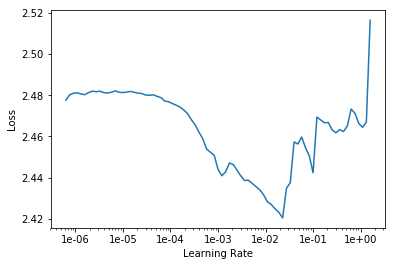

In [0]:
# find optimum learning rate
learn.lr_find()
learn.recorder.plot()

In [0]:
# export

# train model
LSTM_valid_raw_preds = train_model(learn,output_dim=num_targets, lr = 1.0e-3)  

epoch,train_loss,valid_loss,time
0,1.336112,1.252383,00:34


Vaidation accuracy: 53.58%


epoch,train_loss,valid_loss,time
0,0.948893,0.904399,00:33


Vaidation accuracy: 67.22%


epoch,train_loss,valid_loss,time
0,0.716935,0.748940,00:34


Vaidation accuracy: 73.75%


epoch,train_loss,valid_loss,time
0,0.616121,0.681282,00:34


Vaidation accuracy: 76.21%


epoch,train_loss,valid_loss,time
0,0.552609,0.595537,00:33


Vaidation accuracy: 78.93%


epoch,train_loss,valid_loss,time
0,0.490983,0.591842,00:34


Vaidation accuracy: 79.47%


epoch,train_loss,valid_loss,time
0,0.467347,0.567510,00:34


Vaidation accuracy: 80.41%


epoch,train_loss,valid_loss,time
0,0.421044,0.555188,00:34


Vaidation accuracy: 81.39%


epoch,train_loss,valid_loss,time
0,0.379669,0.540867,00:34


Vaidation accuracy: 82.90%


epoch,train_loss,valid_loss,time
0,0.339672,0.545274,00:34


Vaidation accuracy: 82.68%


epoch,train_loss,valid_loss,time
0,0.313055,0.540282,00:34


Vaidation accuracy: 83.12%


epoch,train_loss,valid_loss,time
0,0.291185,0.557511,00:34


Vaidation accuracy: 82.81%


Can I train more epochs here without significant overfitting? Restart training with lower learning rate.

In [0]:
# export

# test set prediction

LSTM_pred_raw = torch.zeros(len(X_test), num_targets)
test_preds = np.zeros((len(X_test)))
learn.model.eval()

for i, x_batch in enumerate(test_loader):
    X = x_batch[0].cuda()
    y_pred = nn.Softmax(dim=-1)(learn.model(X).detach())
    LSTM_pred_raw[i * batch_size:(i + 1) * batch_size] = y_pred
    test_preds[i * batch_size:(i + 1) * batch_size] =  y_pred.argmax(dim=-1).cpu().numpy()
###

# save LSTM prediction
np.savetxt("LSTM_ytest.txt",test_preds.astype(int), fmt='%d')

In [0]:
LSTM_valid_raw_preds.shape

torch.Size([6503, 12])

### CNN Model

In [0]:
# export

# CNN model class
class CNN_Text(nn.Module):
    
    def __init__(self, max_features=28, e_char = 50,  kernel_sizes = [3,4,5,6, 10], num_filters =64, dropout_rate = 0.2, num_targets = 12):
      
        super(CNN_Text, self).__init__()
        
        # max_features: number of alphabets and <s>, </s>
        # e_char: char dimension
        # kernel_sizes: a list of kernel_sizes to consider
        # num_filters: number of filters to consider for each kernel_size
        # num_targets: number of authors
        
        
        self.e_char = e_char
        self.max_features = max_features
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_targets = num_targets
        self.dropout_rate = dropout_rate
        
        in_channels = 1
        out_channles = self.num_filters
        
        num_latent = out_channles*len(kernel_sizes)
        
        
        # layers
        self.embed = nn.Embedding(max_features, e_char)
        self.conv_cnn = nn.ModuleList([nn.Conv2d(in_channels, out_channles, (K, e_char)) for K in kernel_sizes])
        self.dropout = nn.Dropout(dropout_rate)
        
        self.out = nn.Linear(num_latent, num_targets)


    def forward(self, x):
        
        x = self.embed(x)  # (batch, max_seq, e_char)
        
        x = x.unsqueeze(1)  # (batch, in_channels, max_seq, e_char)

        x = [F.relu(conv(x)).squeeze(dim =-1) for conv in self.conv_cnn]  
        # list of tensors with shape (batch, out_channels, max_seq)  # conv(x) --> (batch, out_channels, max_seq, 1)

        x = [F.max_pool1d(i, i.size(2)).squeeze(dim=-1) for i in x]  
        # list of tensors with shape (batch, out_channels) # max pool across char sequence max([:max_seq])

        x = torch.cat(x, 1) # (batch, out_channels*num_kernesl)


        x = self.dropout(x)  # (batch, out_channels*num_kernesl)
        results = self.out(x)  
        
        return results

In [0]:
# export

### CNN model init
model = CNN_Text()
learn = Learner(databunch, model, loss_func=loss_function)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


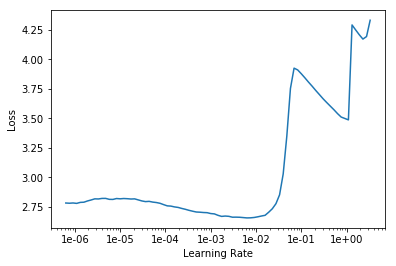

In [0]:
# find learning rate for cnn model
learn.lr_find()
learn.recorder.plot()

In [0]:
# export 

# train cnn model
num_targets=12
CNN_valid_raw_preds = train_model(learn,lr=1.0e-3, output_dim=num_targets)

epoch,train_loss,valid_loss,time
0,0.988871,0.923104,00:13


Vaidation accuracy: 67.08%


epoch,train_loss,valid_loss,time
0,0.796513,0.706745,00:13


Vaidation accuracy: 75.83%


epoch,train_loss,valid_loss,time
0,0.739397,0.694857,00:13


Vaidation accuracy: 76.16%


epoch,train_loss,valid_loss,time
0,0.700474,0.661976,00:13


Vaidation accuracy: 76.90%


epoch,train_loss,valid_loss,time
0,0.682031,0.660802,00:13


Vaidation accuracy: 76.53%


epoch,train_loss,valid_loss,time
0,0.653037,0.652035,00:13


Vaidation accuracy: 77.44%


epoch,train_loss,valid_loss,time
0,0.638092,0.606118,00:13


Vaidation accuracy: 78.93%


epoch,train_loss,valid_loss,time
0,0.624688,0.608692,00:13


Vaidation accuracy: 78.78%


epoch,train_loss,valid_loss,time
0,0.600721,0.604629,00:13


Vaidation accuracy: 79.21%


epoch,train_loss,valid_loss,time
0,0.584746,0.628946,00:13


Vaidation accuracy: 78.61%


epoch,train_loss,valid_loss,time
0,0.574907,0.585400,00:13


Vaidation accuracy: 79.76%


epoch,train_loss,valid_loss,time
0,0.582932,0.592735,00:13


Vaidation accuracy: 79.50%


Observation: CNN model train much faster than LSTM model. It uses spatial pattern recognition. Better results can be achieved by hyperparameter tuning, optimizing training loop, and deeper CNN blocks with highway connection.

In [0]:
# export 
# CNN test set prediction

# test set prediction
CNN_pred_raw = torch.zeros(len(X_test), num_targets)
test_preds = np.zeros((len(X_test)))

learn.model.eval()

for i, x_batch in enumerate(test_loader):
    X = x_batch[0].cuda()
    y_pred = nn.Softmax(dim=-1)(learn.model(X).detach())
    CNN_pred_raw[i * batch_size:(i + 1) * batch_size] = y_pred
    test_preds[i * batch_size:(i + 1) * batch_size] =  y_pred.argmax(dim=-1).cpu().numpy()
###
# save CNN prediction
np.savetxt("CNN_ytest.txt",test_preds.astype(int), fmt='%d')

In [0]:
CNN_valid_raw_preds.shape

torch.Size([6503, 12])

### LSTM with attention

In [0]:
## export

class NeuralNetAttn(nn.Module):
  """ LSTM Neural net model with attention mechanism 
      Uses dot product attention between LSTM outputs at each time step with last-time-step output i.e. encoded sequence
  """
    
  def __init__(self, embed_size, hidden_size, num_targets, dropout_rate = 0.2):
      super(NeuralNetAttn, self).__init__()

      # attributes
      self.num_targets = num_targets

      # layers

      self.lstm1 = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)

      self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)


      self.h_projection= nn.Linear(2*hidden_size, hidden_size, bias=False)
      self.c_projection = nn.Linear(2*hidden_size, hidden_size, bias=False)
      self.att_projection = nn.Linear(2*hidden_size, hidden_size, bias=False)
      self.combined_output_projection = nn.Linear(3*hidden_size, num_targets, bias=False)

      self.dropout = nn.Dropout(dropout_rate)

  def forward(self, h_embedding, lengths=None):

      #h_embedding = self.embedding(x.long())
      #h_embedding = self.embedding_dropout(h_embedding)
      #set_trace()

      h_lstm1,  _ = self.lstm1(h_embedding) # (batch, seq_len, num_directions * hidden_size)
      h_lstm2, (last_hidden, last_cell) = self.lstm2(h_lstm1)

      last_hidden = torch.cat((last_hidden[0,:],last_hidden[1,:]),1)
      last_cell = torch.cat((last_cell[0,:],last_cell[1,:]),1)


      ## Attention layer
      sent_hidden_proj = self.h_projection(last_hidden) # (batch, seq_len, hidden_size)
      sent_cell_proj = self.c_projection(last_cell)

      enc_hiddens_proj = self.att_projection(h_lstm2) # (batch, seq_len, hidden_size)

      aug_last_hidden = torch.unsqueeze(sent_hidden_proj, dim=2) #(b,hidden_size,1)
      e_t = torch.bmm(enc_hiddens_proj,aug_last_hidden) # (b,max_len, hidden_size) * (b,hidden_size,1) --> (b, max_len, 1)
      alpha_t = F.softmax(e_t, dim=1) #(b, src_len)

      #aug_att = torch.unsqueeze(alpha_t,2) #(b, src_len, 1)

      tr_hiddens = h_lstm2.transpose(1,2) #(b,hidden_size*2, src_len)
      a_t = torch.bmm(tr_hiddens,alpha_t) #(b,2*hidden_size,1)
      a_t=a_t.squeeze(dim=-1)
      #set_trace()
      U_t = self.dropout(torch.cat((a_t,sent_hidden_proj), dim=1)) #(b,3*hidden_size)
      result = self.combined_output_projection(U_t) #(b,target_size)

      return result
       

In [0]:
# export
class ModelAttn(nn.Module):
    def __init__(self, LUT, NeuralNetAttn):
        
        super(ModelAttn, self).__init__()
        self.LUT = LUT
        self.Net = NeuralNetAttn
        
    def forward(self, x, lengths=None):
        
        h_embedding = self.LUT(x.long())
        out = self.Net(h_embedding)
        
        return out

In [0]:
# export

# hyperparameters
embed_size =50
hidden_size =128
num_targets = 12


LUT = ModelEmbedding(max_features, embed_size, dropout = 0.3)
NET = NeuralNetAttn(embed_size, hidden_size, num_targets)
model = ModelAttn(LUT, NET)

learn = Learner(databunch, model, loss_func=loss_function)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


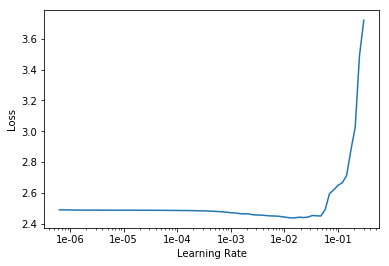

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# export
# training
Attn_valid_raw_preds = train_model(learn,lr=0.005, output_dim=num_targets)    


epoch,train_loss,valid_loss,time
0,1.648774,1.577162,00:34


Vaidation accuracy: 41.86%


epoch,train_loss,valid_loss,time
0,1.483861,1.442771,00:35


Vaidation accuracy: 47.47%


epoch,train_loss,valid_loss,time
0,1.307825,1.240584,00:35


Vaidation accuracy: 56.19%


epoch,train_loss,valid_loss,time
0,1.162830,1.119835,00:35


Vaidation accuracy: 60.73%


epoch,train_loss,valid_loss,time
0,1.010101,0.977059,00:35


Vaidation accuracy: 66.03%


epoch,train_loss,valid_loss,time
0,0.912864,0.889594,00:35


Vaidation accuracy: 70.15%


epoch,train_loss,valid_loss,time
0,0.791680,0.777775,00:36


Vaidation accuracy: 73.09%


epoch,train_loss,valid_loss,time
0,0.693648,0.732023,00:35


Vaidation accuracy: 74.70%


epoch,train_loss,valid_loss,time
0,0.629358,0.655777,00:35


Vaidation accuracy: 77.56%


epoch,train_loss,valid_loss,time
0,0.584983,0.660011,00:35


Vaidation accuracy: 77.58%


epoch,train_loss,valid_loss,time
0,0.517621,0.583553,00:35


Vaidation accuracy: 79.79%


epoch,train_loss,valid_loss,time
0,0.481281,0.577090,00:35


Vaidation accuracy: 80.06%


Things to do:
1. Check if computations are implemented correctly
2. Implement token mask over padded tokens
3. Better optimization scheme

In [0]:
# export 
# Attention model test set prediction

# test set prediction
Attn_pred_raw = torch.zeros(len(X_test), num_targets)
test_preds = np.zeros((len(X_test)))

learn.model.eval()

for i, x_batch in enumerate(test_loader):
    X = x_batch[0].cuda()
    y_pred = nn.Softmax(dim=-1)(learn.model(X).detach())
    Attn_pred_raw[i * batch_size:(i + 1) * batch_size] = y_pred
    test_preds[i * batch_size:(i + 1) * batch_size] =  y_pred.argmax(dim=-1).cpu().numpy()
###
# save Attn prediction
np.savetxt("Attn_ytest.txt",test_preds.astype(int), fmt='%d')

In [0]:
Attn_valid_raw_preds.shape

torch.Size([6503, 12])

### Simple blending

In [0]:
# export
# simple averaging of three models (better ensemble can be performed with xgboost/lightgbm)

final_valid_raw_preds = 0.3*LSTM_valid_raw_preds + 0.4*CNN_valid_raw_preds + 0.3*Attn_valid_raw_preds
valid_preds = final_valid_raw_preds.argmax(dim=-1).cpu().numpy()
print("Expected accuracy: {:.2f}%".format((valid_preds == y_valid).sum()/len(valid_preds)*100 ))

Expected accuracy: 85.64%


In [0]:
# export
final_test_raw_preds = 0.3*LSTM_pred_raw + 0.4*CNN_pred_raw + 0.3*Attn_pred_raw
test_preds = final_test_raw_preds.argmax(dim=-1).cpu().numpy()
# save test preds
np.savetxt("ytest.txt",test_preds.astype(int), fmt='%d')

### Export code

In [0]:
! pip install fire

  Stored in directory: /root/.cache/pip/wheels/2a/1a/4d/6b30377c3051e76559d1185c1dbbfff15aed31f87acdd14c22
Successfully built fire


In [0]:
!python notebook2script.py Q4-vf.ipynb

Converted Q4-vf.ipynb to nb_Q4-vf.py


In [0]:
########### End ###############